In [1]:
!pip install textract
!pip install sentencepiece
!pip install transformers


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import textract
import re, json, os
from os.path import join
from bs4 import BeautifulSoup
from gensim.summarization import keywords
import warnings
warnings.filterwarnings("ignore")
from transformers import AutoModelWithLMHead, AutoTokenizer

import nltk
import spacy
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt

c:\Users\peter\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


In [3]:
nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Data extraction

In [4]:
def extract_content_from_pdf(filename):
    # text variable which contains all the text derived from our PDF file
    full_text = textract.process(filename, method='pdfminer', language='eng').decode('utf-8')
    return full_text.encode('ascii','ignore').lower().decode('utf-8')

def extract_keyword(full_text):
    keyword_summaries = keywords(text = full_text, split = "\n", scores = True)
    data = pd.DataFrame(keyword_summaries, columns = ["keyword", "score"])
    return data.sort_values("score", ascending = False)

In [5]:
SEMESTER = "s23"
oli_org = open(f'{SEMESTER}/organizations/default/organization.xml', "r").read()
oli_org_soup = BeautifulSoup(oli_org, "lxml")

In [6]:
def get_module_unit_from_org(page_id):
    try:
        resource_ref = oli_org_soup.find('resourceref', {'idref': page_id})
        curr_module = resource_ref.find_parent('module').find('title').get_text()
        curr_unit = resource_ref.find_parent('unit').find('title').get_text()
        return curr_module, curr_unit
    except:
        return None, None

def is_header(p):
    # a header paragraph should have the form <p><em>...</em></p>, with no other inner tag
    n_contents = len([c for c in p.contents if not str(c.string).isspace()])
    return p.find("em") is not None and n_contents == 1

def get_file_content(filename):
    with open(f'{SEMESTER}/content/x-oli-workbook_page/' + filename ) as file:
        soup = BeautifulSoup(file.read(), 'lxml')
    page_id = soup.find('workbook_page')['id']
    curr_module, curr_unit = get_module_unit_from_org(page_id)
    title = soup.find("title").get_text().strip()   
    
    # extract the sub-headers <p><em>text</em></p> and remove them from the text content
    sub_headers = []
    for p in soup.find_all("p"):
        if is_header(p):
            sub_headers.append(p.find("em").get_text().strip())
            p.extract()
    
    all_text = "\n".join(p.get_text().strip() for p in soup.find_all("p")[1:])
    
    all_text = re.sub(r"\n+", r"\n", all_text.strip())
    pattern = r"\\\w+\d+"

    all_text = re.sub(pattern, "", all_text)
    all_text = all_text.replace("$", "")
    all_text = all_text.replace("\\n",'')
    all_text = all_text.replace("\\t",'')
    all_text = all_text.replace("\\r",'')
    all_text = all_text.replace("\\xcf",'')
    all_text = all_text.replace('http://cnx.org/contents/85abf193-2bd2-4908-8563-90b8a7ac8df6@9.312', '')
    return {
        "Unit" : curr_unit, "Module" : curr_module, "Title" : title,
        "Text": all_text, "Subheaders" : ",".join(sub_headers)
    }

In [23]:
df_oli = pd.DataFrame([
    get_file_content(filename)
    for filename in os.listdir(f"{SEMESTER}/content/x-oli-workbook_page")
    if filename.endswith(".xml")
]).dropna()
df_oli.to_csv("oli_content.csv", index = False)
df_oli.reset_index(inplace=True)
df_oli.head()

,index,Unit,Module,Title,Text,Subheaders
0,2,Composition of Substances and Solutions,Introduction,Introduction to Composition of Substances and ...,Swimming pools have long been a popular means ...,
1,3,Chemical Bonding and Molecular Geometry,Introduction,Introduction to Chemical Bonding and Molecular...,It has long been known that pure carbon occurs...,
2,4,Electronic Structure and Periodic Properties,Introduction,Electronic Structure and Periodic Properties I...,The Crab Nebula consists of remnan...,
3,5,Gases,Introduction,Introduction to Gases,We are surrounded by an ocean of gasthe atmosp...,
4,7,Reactions and Stoichiometry,Introduction,Introduction to Chemical Reactions and Stoichi...,Solid-fuel rockets are a central feature in th...,


Knowledge Graph Creation

In [17]:
spacy.explain('dobj')

'direct object'

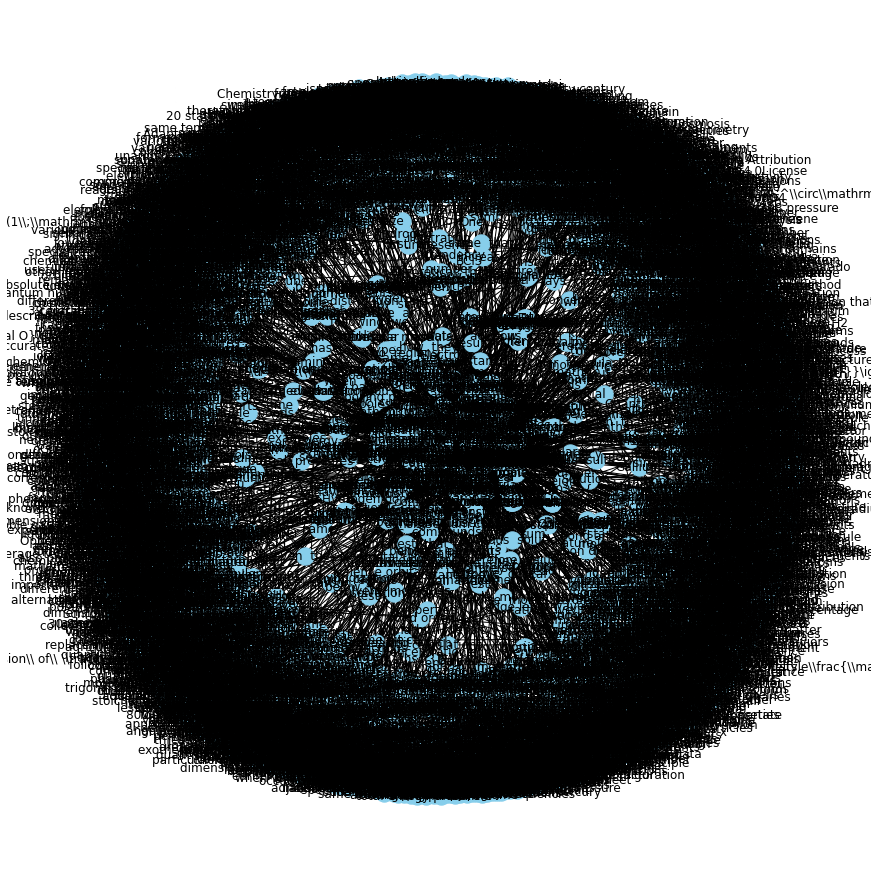

In [34]:
# Approach One: https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

sentences_list = list(df_oli['Text'])
text_content = " ".join(sentences_list).replace("\n", " ")
sentences = nltk.sent_tokenize(text_content)\

filtered_sentences = list()
relations = list()

for s in sentences:
  filtered_sentences.append(get_entities(s))
  relations.append(get_relation(s))

# Build the actual KG
source = [i[0] for i in filtered_sentences]
target = [i[1] for i in filtered_sentences]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

kg_df.to_csv('knowledge_graph.csv')

G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Keywords

In [8]:
def get_keywords(text):
  # Approach 1: Extract from text somehow - custom rules
  # Approach 2: extract_keywords() function from gensim
  # Approach 3: Syntactic parsing
  # Approach 4: External Knowledge Graph
  # Approach 5: Hard-Code
  words = keywords(text).split('\n')
  #keywords = ['ranking', 'sampling', 'Feature Engineering', 'Clustering']
  return words

Answer generation

In [24]:
def get_answer(content):
  keywords = []
  if content:
    keywords = get_keywords(content)
    #for word in keywords:
     # if word in content:
    
  return keywords
  

df_oli['answer'] = df_oli.apply(lambda row : get_answer(row['Text']), axis=1)

display(df_oli.head())

,index,Unit,Module,Title,Text,Subheaders,answer
0,2,Composition of Substances and Solutions,Introduction,Introduction to Composition of Substances and ...,Swimming pools have long been a popular means ...,,"[pools, pool, calcium, proper, compounds, comp..."
1,3,Chemical Bonding and Molecular Geometry,Introduction,Introduction to Chemical Bonding and Molecular...,It has long been known that pure carbon occurs...,,"[structure, structures, atoms, carbon, forms, ..."
2,4,Electronic Structure and Periodic Properties,Introduction,Electronic Structure and Periodic Properties I...,The Crab Nebula consists of remnan...,,"[light, nebula, filaments, astronomers, energy..."
3,5,Gases,Introduction,Introduction to Gases,We are surrounded by an ocean of gasthe atmosp...,,"[behavior, gas, gases, theoretical, tire, ball..."
4,7,Reactions and Stoichiometry,Introduction,Introduction to Chemical Reactions and Stoichi...,Solid-fuel rockets are a central feature in th...,,"[space, chemicals, chemical, rocket, amounts, ..."


In [25]:
df_oli = df_oli.explode('answer')


In [27]:
df_oli.to_csv("oli_content_with_keywords.csv", index = False)

In [32]:
print(df_oli.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4968 entries, 0 to 223
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       4968 non-null   int64 
 1   Unit        4968 non-null   object
 2   Module      4968 non-null   object
 3   Title       4968 non-null   object
 4   Text        4968 non-null   object
 5   Subheaders  4968 non-null   object
 6   answer      4957 non-null   object
dtypes: int64(1), object(6)
memory usage: 310.5+ KB
None


Question Generation

In [14]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")

def get_question(answer, context, max_length=64):
  input_text = "answer: %s  context: %s </s>" % (answer, context)
  features = tokenizer([input_text], return_tensors='pt')

  output = model.generate(input_ids=features['input_ids'], 
               attention_mask=features['attention_mask'],
               max_length=max_length)

  return tokenizer.decode(output[0])[16:]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [18]:
def populate_qa_dict(content, ans, dictionary):
  #for ans in answers_list:
  question = get_question(ans, content)
  dictionary[question] = ans

In [26]:
qa_pairs = dict()
df_oli.apply(lambda row : populate_qa_dict(row['Text'], row['answer'], qa_pairs), axis=1)

#for key in qa_pairs.keys():
 # print(key)
  #print(qa_pairs[key])
  #print("***")

Token indices sequence length is longer than the specified maximum sequence length for this model (778 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

In [22]:
df = pd.DataFrame(qa_pairs.items(), columns=['Question', 'Answer'])
display(df.head())

,Question,Answer
0,What type of water is used for recreation?</s>,pools
1,What type of water is treated with chemicals t...,pool
2,What is added to water in the form of an ionic...,calcium
3,What is the importance of measuring the amount...,proper
4,What chemical is added to pool water to preven...,compounds
